Notebook purpose

- Replicate analysis of davenport2020spending

In [240]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
d = aws.S3BucketManager('3di-project-entropy')
d.list()

['3di-project-entropy/entropy_000.parquet',
 '3di-project-entropy/entropy_777.parquet']

In [242]:
df = aws.s3read_parquet('s3://3di-data-mdb/raw/mdb_000.parquet')


In [243]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
df.head(2)

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance
0,3631012,2013-01-07,17277,7.270000,tesco stores 5051 <mdbremoved>,tesco,supermarket,False,ox10 9,2013-02-10,NaN,1974.0,2013-02-11,230282,2015-05-21 06:47:00,virgin money,credit card,2014-07-18,2017-08-14,True,NaN,tesco supermarket,"food, groceries, household",NaN,supermarket,201301,NaN
1,3631009,2013-01-07,17277,89.790001,bensons service statio wallingfordmerchant <mdbremoved>,NaN,fuel,False,ox10 9,2013-02-10,NaN,1974.0,2013-02-11,230282,2015-05-21 06:47:00,virgin money,credit card,2014-07-18,2019-04-09,True,NaN,NaN,fuel,NaN,fuel,201301,NaN


## Savings account balances

In [141]:
df.groupby('account_id').account_type.first().value_counts()

current        99
savings        60
credit card    30
other           5
Name: account_type, dtype: int64

### By account type

In [215]:
savings = df[df.account_type == 'savings']

daily_balances = (savings.set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .assign(account_label=lambda x: x.account_id.astype('str') + '-' + x.user_id.astype('str')))

pivot = daily_balances.pivot_table('balance', 'date', 'account_label')

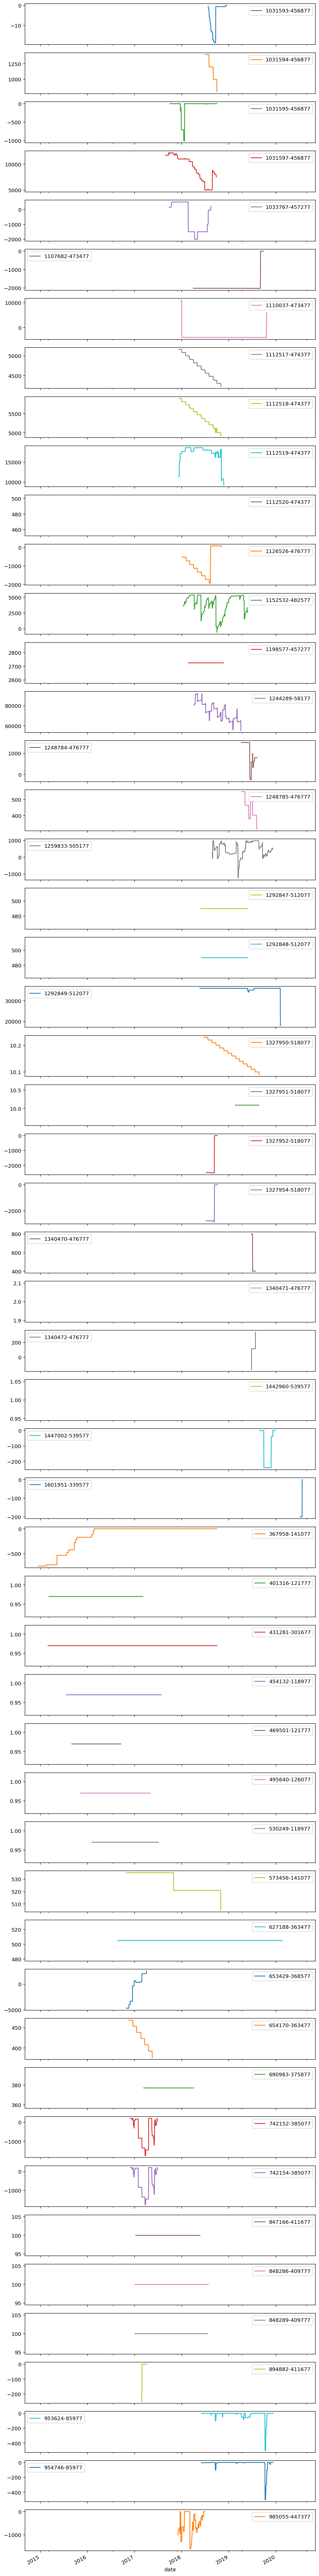

In [239]:
pivot.iloc[:,:].plot(subplots=True, figsize=(10, 100));

### By user

In [195]:
user_sample = pd.Series(df.user_id.unique()).sample(random_state=2312, n=10)
sample = df[df.user_id.isin(user_sample)]

In [189]:
# savings = df[df.account_type == 'savings']

daily_balances = (sample.set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str')))

daily_balances.head(3)

,account_id,account_type,user_id,date,balance,account_label
0,96284,current,30377,2013-09-06,-13714.03125,current-96284
1,96284,current,30377,2013-09-07,-13714.03125,current-96284
2,96284,current,30377,2013-09-08,-13714.03125,current-96284


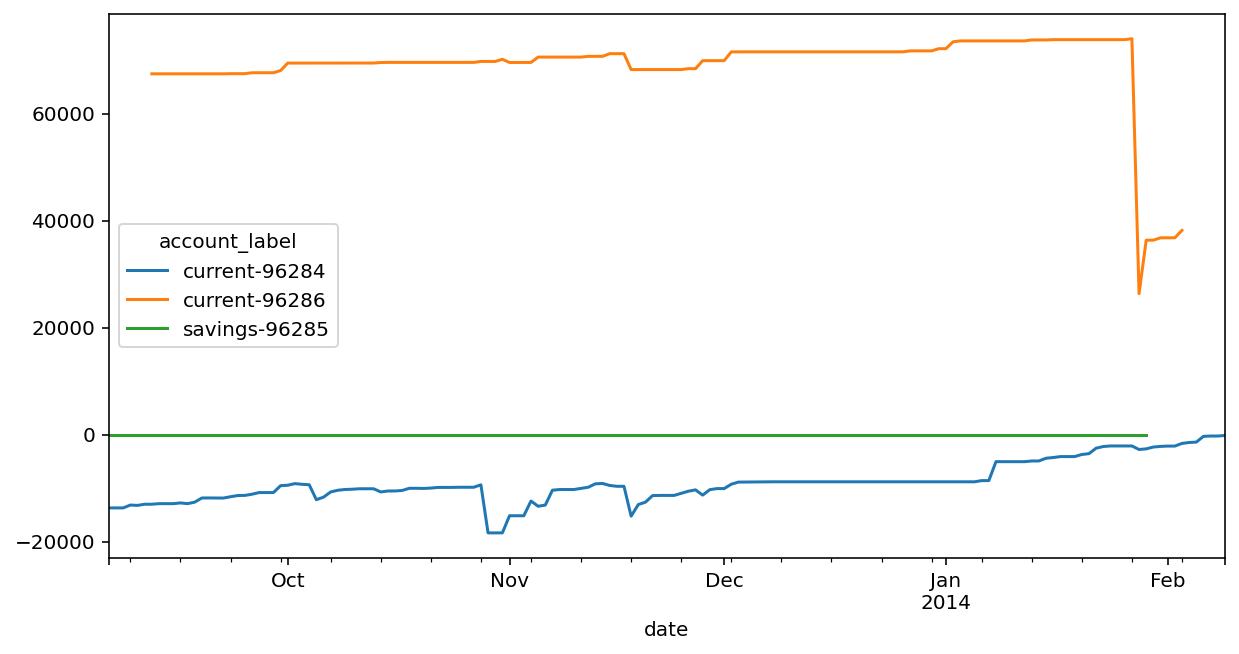

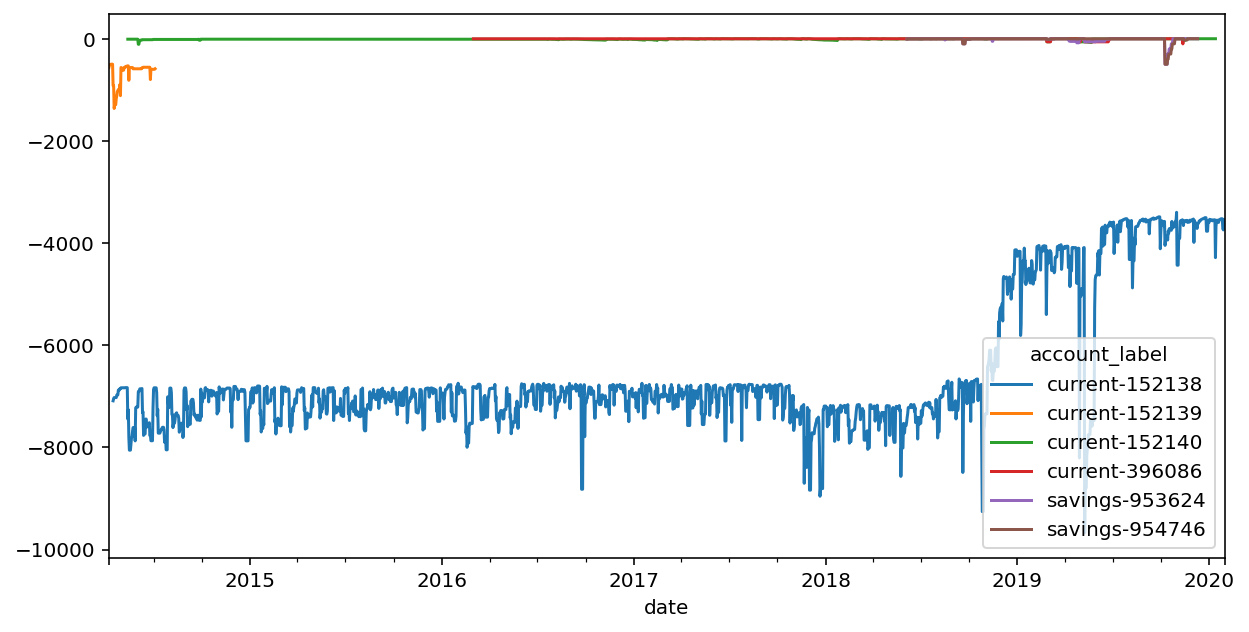

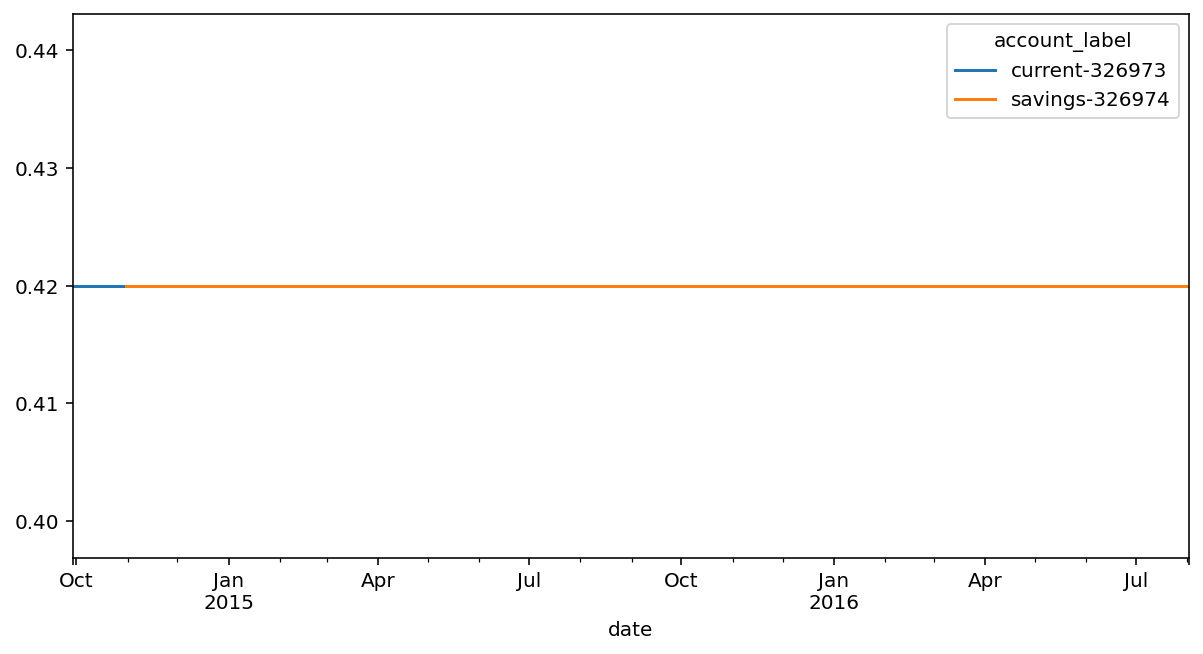

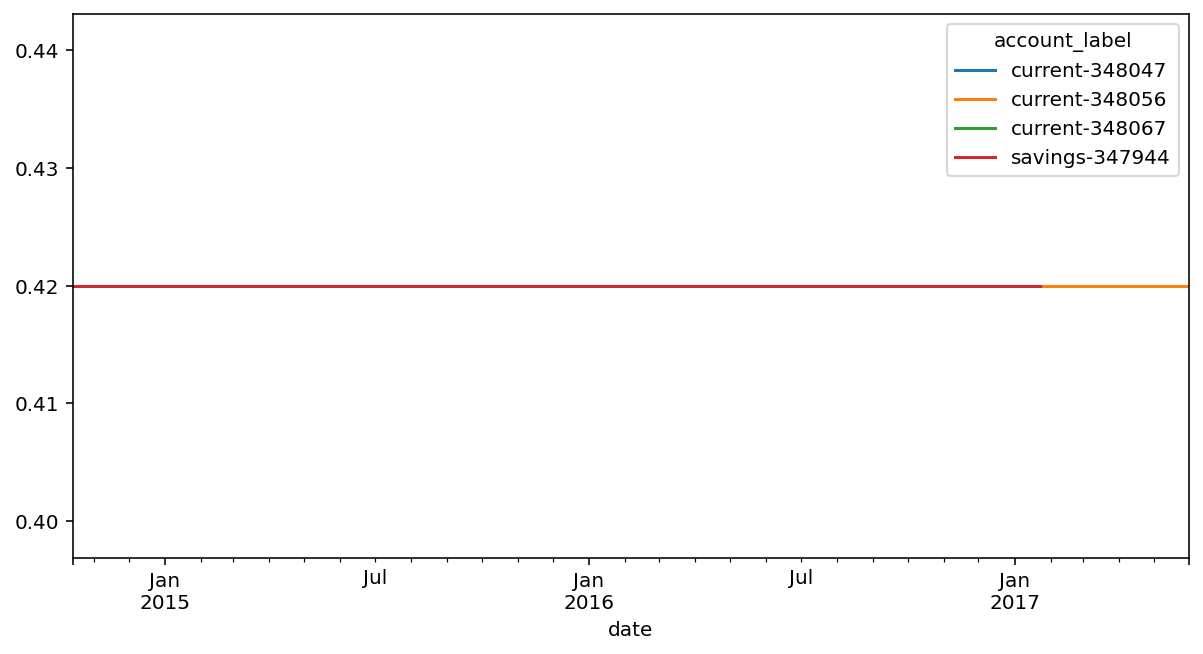

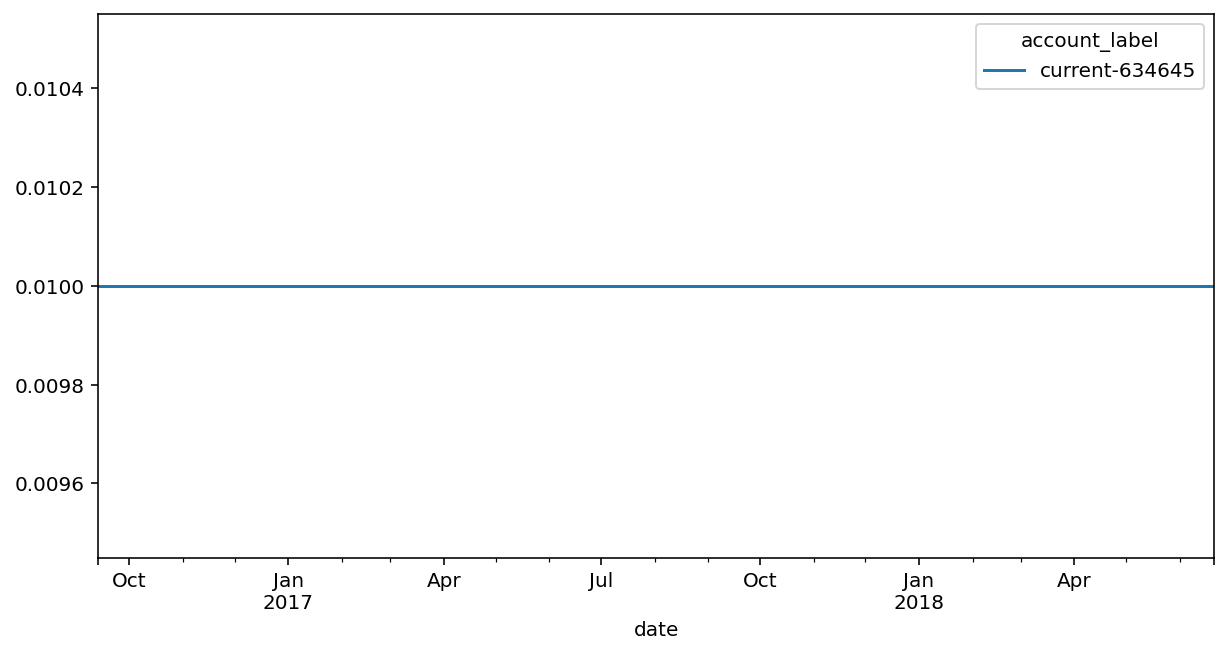

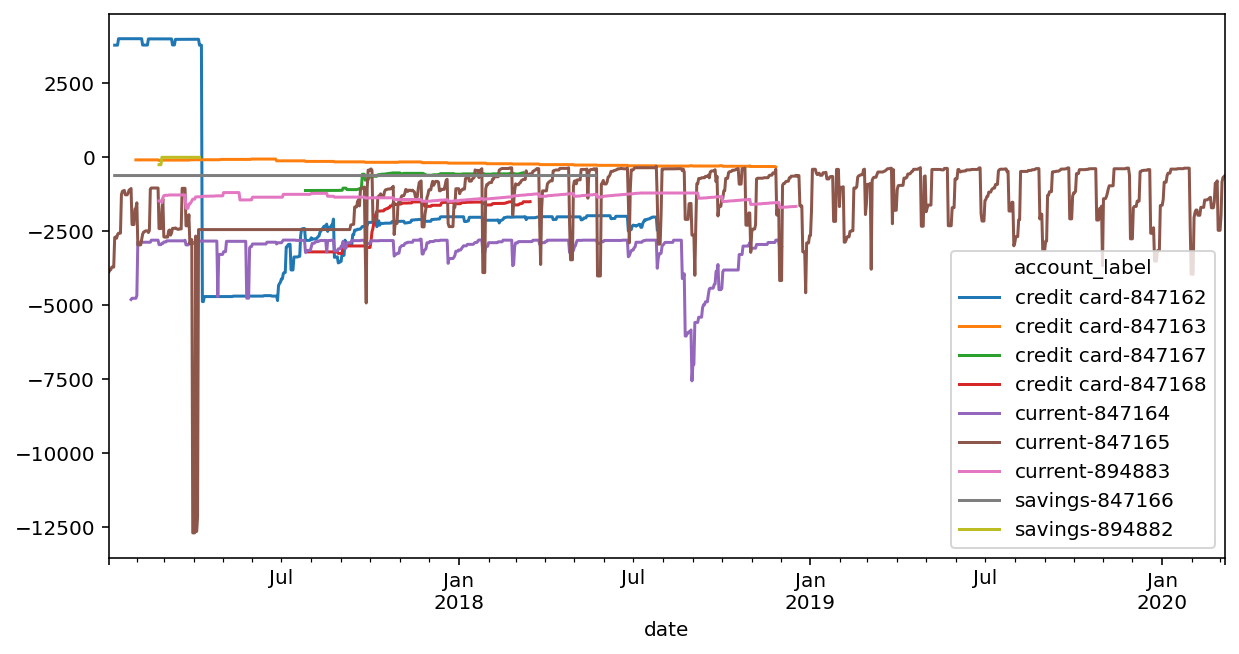

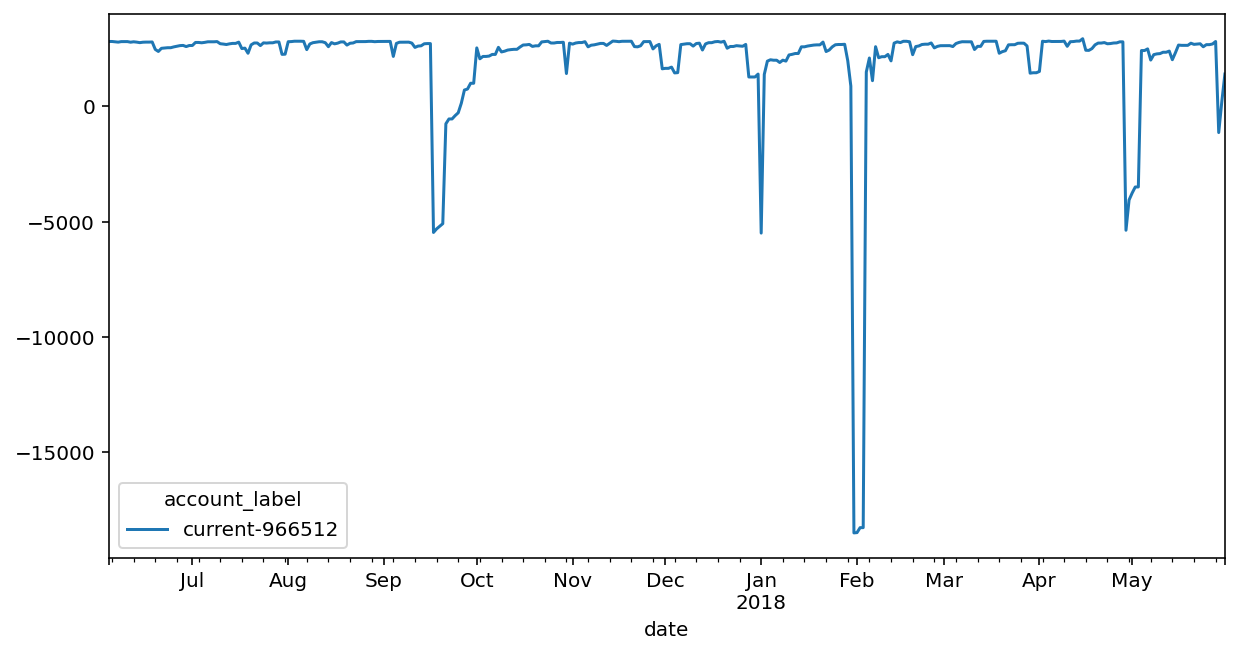

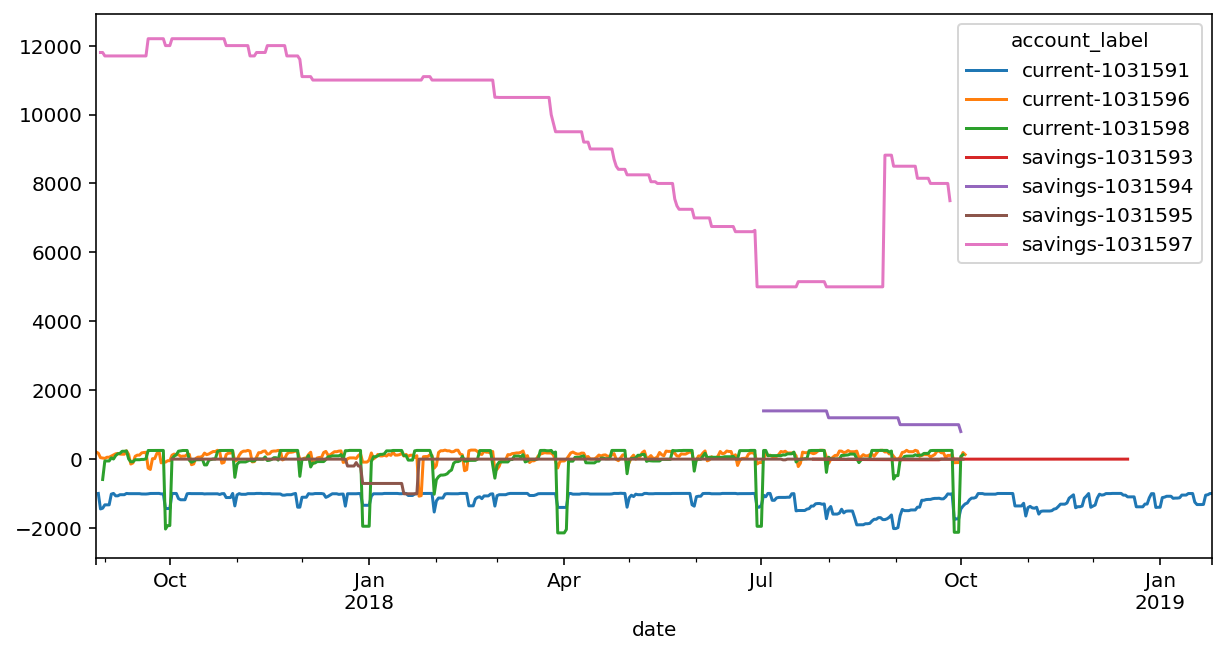

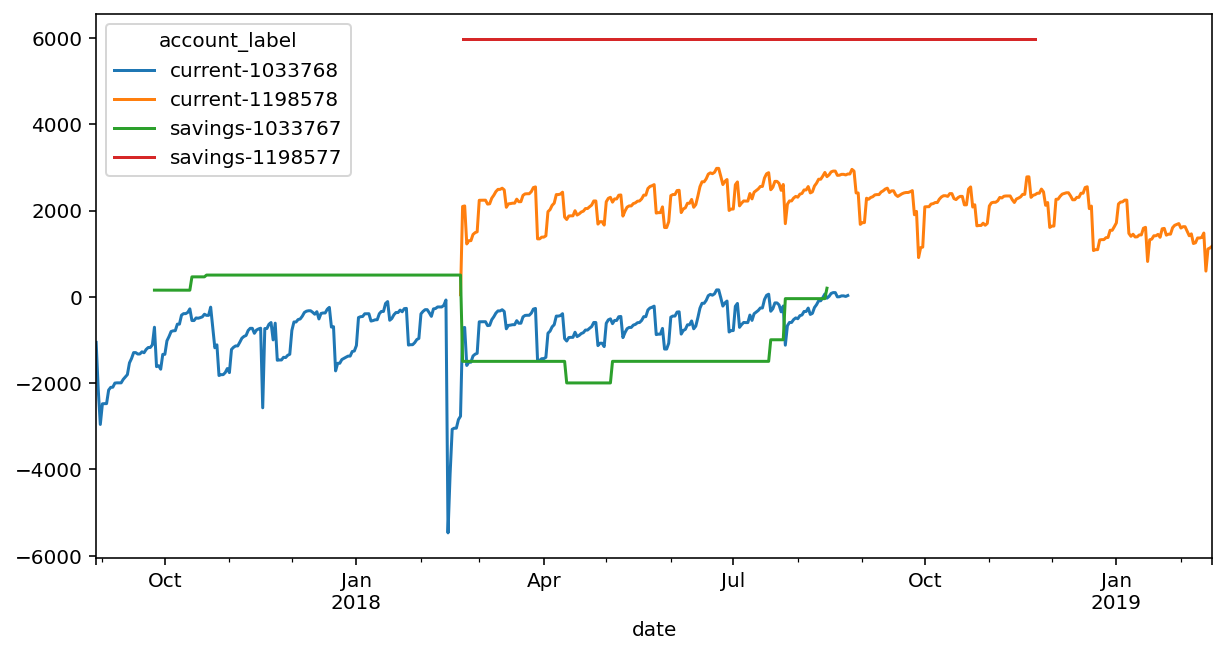

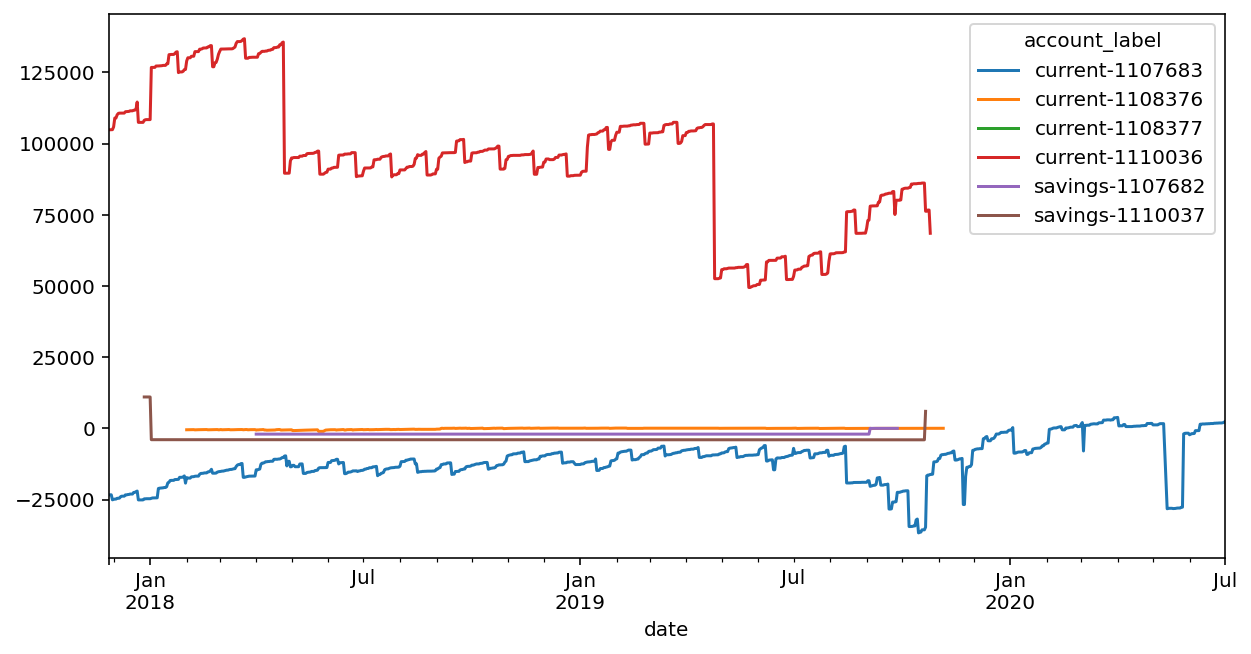

In [194]:
for user, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5));

In [6]:
user = 364777
dfu = df[df.user_id == user]
dfu.head(3)

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym
4227,175404425,2016-09-13,364777,-209.449997,bank giro credit ref <mdbremoved>,NaN,child support,True,wa2 9,2016-12-12,NaN,1975.0,2016-12-12,634645,2018-06-22 13:38:00,santander,current,2016-12-13,2017-08-11,False,0.0,NaN,NaN,child support,child support,201609
4228,175404422,2016-09-14,364777,5.990000,"direct debit payment to phones 4 u care ref xxxx0114, mandate no 0049",phones 4 u,mobile,True,wa2 9,2016-12-12,NaN,1975.0,2016-12-12,634645,2018-06-22 13:38:00,santander,current,2016-12-13,1900-01-01,True,0.0,phones 4 u,mobile,NaN,mobile,201609
4229,175404423,2016-09-14,364777,31.180000,"direct debit payment to paypal payment ref 4fqx2226d7m46, mandate no 0055",paypal,paypal account,True,wa2 9,2016-12-12,NaN,1975.0,2016-12-12,634645,2018-06-22 13:38:00,santander,current,2016-12-13,2017-08-11,True,0.0,paypal,enjoyment,paypal account,paypal account,201609


In [7]:
s = dfu.set_index('date').resample('D').amount.sum()[:5].rename('amount')
cs = s.cumsum().rename('cumulative_sum')
lb = pd.Series([1000]*5, s.index, name='latest_balance')
b = pd.Series([np.nan]*5, s.index, name='balance')
dd = pd.DataFrame(data=[s, cs, lb, b]).T
dd

,amount,cumulative_sum,latest_balance,balance
date,,,,
2016-09-13,-209.449997,-209.449997,1000.0,NaN
2016-09-14,109.049995,-100.400002,1000.0,NaN
2016-09-15,-1914.340088,-2014.740112,1000.0,NaN
2016-09-16,300.000000,-1714.740112,1000.0,NaN
2016-09-17,209.360001,-1505.380127,1000.0,NaN


In [10]:
latest_balance = dd.latest_balance.iloc[0]
last_refreshed_date = pd.Timestamp('2016-09-22')

In [19]:
dd.iloc[dd.index.get_loc(last_refreshed_date, method='ffill')]

amount             209.360001
cumulative_sum   -1505.380127
latest_balance    1000.000000
balance                   NaN
Name: 2016-09-17 00:00:00, dtype: float64

In [294]:
# calc starting balance
pre_refresh = dd.cumulative_sum.truncate(after=last_refreshed_date)
cumsum_total = pre_refresh[-1]
starting_balance = latest_balance - cumsum_total
starting_balance

2505.380126953125

Different spending measures:
- Account balances
- Payments into savings


In [328]:
latest_balance = dfu.latest_balance.iloc[0]
last_refreshed_date = dfu.account_last_refreshed.iloc[0]

# calc cumsum
cumsum = dfu.set_index('date').resample('D').amount.sum().cumsum()

# calc starting balance
pre_refresh = cumsum.truncate(after=last_refreshed_date)
cumsum_total = pre_refresh[-1]
starting_balance = latest_balance - cumsum_total

# # get corrected balances
cumsum.add(starting_balance)

date
2016-09-13     328.280762
2016-09-14     437.330780
2016-09-15   -1477.009277
2016-09-16   -1177.009277
2016-09-17    -967.649353
                 ...     
2018-06-17    1178.800049
2018-06-18    1178.800049
2018-06-19    1047.600098
2018-06-20    1054.520020
2018-06-21       0.000000
Freq: D, Name: amount, Length: 647, dtype: float32

In [364]:
cr.calc_balances(df)

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balances
0,20201743,2014-02-24,58777,10.00,lnk po woodgate 04 cd 2813 22feb14,NaN,cash,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-10-23,True,8.380000,personal,cash,NaN,cash,201402,16.009975
1,20201744,2014-02-24,58777,-5.00,paypal 22 <mdbremoved>,paypal,paypal account,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-11-13,False,8.380000,paypal,enjoyment,NaN,paypal account,201402,16.009975
2,20201749,2014-02-25,58777,40.00,lnk birmingham new cd 2813 25feb14,NaN,cash,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-10-23,True,8.380000,personal,cash,NaN,cash,201402,-151.010025
3,20201698,2014-02-25,58777,190.00,lnk po woodgate 04 cd 0412 25feb14,NaN,cash,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124625,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-10-23,True,0.990000,personal,cash,NaN,cash,201402,-21.469992
4,20201748,2014-02-25,58777,-79.00,<mdbremoved> xxxxxx xxxx5664,NaN,transfers,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-08-13,False,8.380000,personal,transfers,NaN,transfers,201402,-151.010025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,593517061,2019-08-14,476777,17.75,"card payment to victor hugo delicatess,17.75 gbp, rate 1.00/gbp on xx-xx-2019",NaN,"food, groceries, household",False,eh11 1,2018-12-22,NaN,1981.0,2018-12-22,1126525,2019-08-22 01:49:00,santander,current,2019-08-15,1900-01-01,True,1182.380005,NaN,"food, groceries, household",NaN,"food, groceries, household",201908,1074.390015
12672,594105671,2019-08-15,476777,9.59,"card payment to lloyds pharmacy,9.59 gbp, rate 1.00/gbp on xx-xx-2019",lloyds pharmacy,"medical, dental, eye care",False,eh11 1,2018-12-22,NaN,1981.0,2019-04-10,1248786,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,59.860001,lloyds pharmacy,"medical, dental, eye care",NaN,"medical, dental, eye care",201908,59.860004
12673,594105673,2019-08-15,476777,100.00,"standing order via faster payment to mbna reference xxxxxxxxxxxx2814 , <mdbremoved>",mbna,credit card,False,eh11 1,2018-12-22,NaN,1981.0,2018-12-22,1126525,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,1182.380005,mbna,credit card,NaN,credit card,201908,1182.380005
12674,594105674,2019-08-15,476777,7.99,"direct debit payment to paypal payment ref 52jx2227fg5gy, mandate no 0012",paypal,enjoyment,False,eh11 1,2018-12-22,NaN,1981.0,2018-12-22,1126525,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,1182.380005,paypal,enjoyment,NaN,enjoyment,201908,1182.380005


In [359]:
df.merge(k, validate='m:1')

,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balances
0,20201743,2014-02-24,58777,10.00,lnk po woodgate 04 cd 2813 22feb14,NaN,cash,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-10-23,True,8.380000,personal,cash,NaN,cash,201402,16.009975
1,20201744,2014-02-24,58777,-5.00,paypal 22 <mdbremoved>,paypal,paypal account,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-11-13,False,8.380000,paypal,enjoyment,NaN,paypal account,201402,16.009975
2,20201749,2014-02-25,58777,40.00,lnk birmingham new cd 2813 25feb14,NaN,cash,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-10-23,True,8.380000,personal,cash,NaN,cash,201402,-151.010025
3,20201748,2014-02-25,58777,-79.00,<mdbremoved> xxxxxx xxxx5664,NaN,transfers,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2017-08-13,False,8.380000,personal,transfers,NaN,transfers,201402,-151.010025
4,20201747,2014-02-25,58777,-104.32,child tax credit,NaN,benefits_income,True,b32 3,2014-05-19,NaN,1979.0,2014-05-19,124626,2015-07-17 07:23:00,halifax personal banking,current,2014-07-18,2019-04-09,False,8.380000,public sector,family benefits,NaN,family benefits,201402,-151.010025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671,593517044,2019-08-14,476777,10.25,"card payment to sainsburys s/mkts,10.25 gbp, rate 1.00/gbp on xx-xx-2019",sainsburys,"food, groceries, household",False,eh11 1,2018-12-22,NaN,1981.0,2019-04-10,1248786,2019-08-22 01:49:00,santander,current,2019-08-15,1900-01-01,True,59.860001,sainsburys supermarket,"food, groceries, household",NaN,"food, groceries, household",201908,37.270004
12672,594105671,2019-08-15,476777,9.59,"card payment to lloyds pharmacy,9.59 gbp, rate 1.00/gbp on xx-xx-2019",lloyds pharmacy,"medical, dental, eye care",False,eh11 1,2018-12-22,NaN,1981.0,2019-04-10,1248786,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,59.860001,lloyds pharmacy,"medical, dental, eye care",NaN,"medical, dental, eye care",201908,59.860004
12673,594105672,2019-08-15,476777,13.00,"card payment to sainsburys s/mkts,13.00 gbp, rate 1.00/gbp on xx-xx-2019",sainsburys,"food, groceries, household",False,eh11 1,2018-12-22,NaN,1981.0,2019-04-10,1248786,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,59.860001,sainsburys supermarket,"food, groceries, household",NaN,"food, groceries, household",201908,59.860004
12674,594105673,2019-08-15,476777,100.00,"standing order via faster payment to mbna reference xxxxxxxxxxxx2814 , <mdbremoved>",mbna,credit card,False,eh11 1,2018-12-22,NaN,1981.0,2018-12-22,1126525,2019-08-22 01:49:00,santander,current,2019-08-16,1900-01-01,True,1182.380005,mbna,credit card,NaN,credit card,201908,1182.380005
